In [1]:
import sys
path = ".."
if path not in sys.path:
    sys.path.insert(0, path)

In [ ]:
!pip install numpy==1.26.4

In [ ]:
import numpy as np
from data_retrieval import lipade_groundtruth
from clustering import getPredictionFromThreshold
import evaluators
import csv

In [3]:
corpus = "lipade_groundtruth"
type = "image"
method = "simclr_" + "degrad_" + "loss1_lr_50"

distancePath = "../representation/" + type + "/results/distance/" + corpus + "/" + method + ".npy"
distance = np.load(distancePath)

In [4]:
_,_,y = lipade_groundtruth.getDataset(mode="similar")

In [ ]:
!pip install numpy==2.0.0

In [5]:
thresholds_precision = 1000
thresholds = np.linspace(0, 1, thresholds_precision) # ((0.95, 1) for sift-absolute)

precisions, recalls, f1s = evaluators.p_r_f1_byThresholds(thresholds, distance, y)

Thresholds: 100%|██████████| 1000/1000 [01:12<00:00, 13.86it/s]


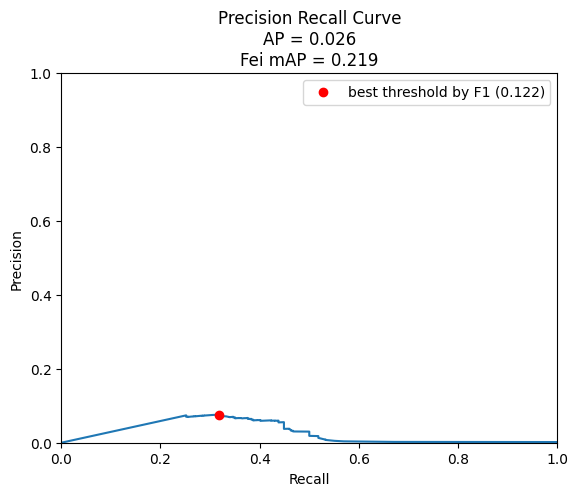

In [6]:
AP, bestThresholdIndex = evaluators.pr_curve(precisions, recalls, f1s, other=("Fei mAP", evaluators.fei_mAP(y, distance)), save="evaluation/" + corpus + "/" + method + ".png")

In [7]:
thresholdsClass = np.linspace(0, 1, int(thresholds_precision / 10)) # ((0.95, 1) for sift-absolute)
precisions_per_class, recalls_per_class = evaluators.p_r_class_byThresholds(thresholdsClass, distance, y)

Thresholds: 100%|██████████| 100/100 [01:24<00:00,  1.19it/s]


In [8]:
with open('evaluation/' + corpus + '/map_a.csv', mode='r') as infile:
    reader = csv.reader(infile)
    map_dict = {rows[0]:rows[1] for rows in reader}

map_dict[method] = "{:.3f}".format(evaluators.goncalves_mAP(precisions_per_class, recalls_per_class))

In [9]:
with open('evaluation/' + corpus + '/map_a.csv', mode='w') as outfile:
    res_dict = csv.writer(outfile)
    res_dict.writerows(map_dict.items())

In [10]:
bestPredictedY = getPredictionFromThreshold(thresholds[bestThresholdIndex], distance)
np.save("clusters/" + corpus + "/" + method + ".npy", bestPredictedY)

# Aucun rapport :

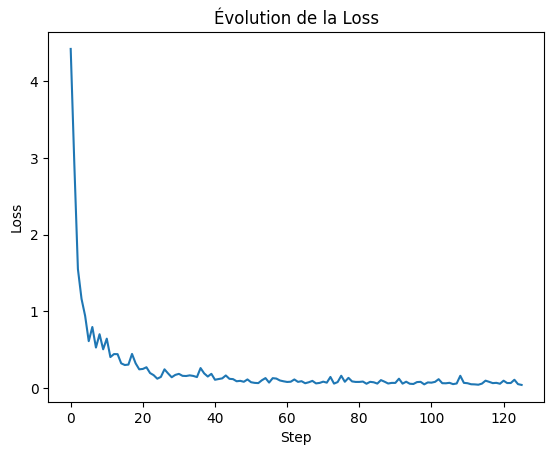

In [64]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

event_path = "C:/Users/rapha/Documents/Cours/Master/Stage/logs/SimCLR_moi1_lr/events.out.tfevents.1741612090.node04.113000.0"
values = []

for event in tf.compat.v1.train.summary_iterator(event_path):
    for value in event.summary.value:
        if value.tag == "Loss/train":
            values.append(value.simple_value)


event_path = "C:/Users/rapha/Documents/Cours/Master/Stage/logs/SimCLR_moi1_lr2/events.out.tfevents.1741628518.node10.87379.0"
for event in tf.compat.v1.train.summary_iterator(event_path):
    for value in event.summary.value:
        if value.tag == "Loss/train":  # Remplace "loss" par le nom exact de ton tag
            values.append(value.simple_value)

# Plot avec Matplotlib
plt.plot(values, label="Loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Évolution de la Loss")
plt.show()
